# **Project Pipeline**

| **Steps**                                              | **Script files**                          |
|-----------------------------------------------------------|-------------------------------------------|
| 1) Read and pre-process data                              | pre_processing.py                         |
| 2) Feature engineering                                    | feature_engineering.py                    |
| 3) Train models                                           | model_training.py, <br>tree_model_training.py |
| 4) Predict on test_features <br>and write submission file | final_predict.py                          |

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

import sys
sys.path.append('..')  # add the parent directory to the Python path

import scripts.pre_processing as pp
import scripts.feature_engineering as fe
import scripts.tree_model_training as tm
import scripts.linear_model_training as lm
from scripts.model_evaluation import regression_evaluation
import scripts.final_predict as fp

## 1) Pre-process data

In [3]:
# Read in data files 
train_features = pd.read_csv('../data/dengue_features_train.csv')
train_target = pd.read_csv('../data/dengue_labels_train.csv')
test_features = pd.read_csv('../data/dengue_features_test.csv')

In [4]:
# Merge features and target data
data = pp.merge_data(train_features, train_target, test_features, inc_test=False)

# Run processing and split by city
train_iq = pp.pre_process(data, 'iq', remove_anomalies=True, inc_test=False)
train_sj = pp.pre_process(data, 'sj', remove_anomalies=True, inc_test=False)

# Run checks for missing values
assert train_iq.isnull().any().any() == False
assert train_sj.isnull().any().any() == False
Xy_iq = train_iq.copy()
Xy_sj = train_sj.copy()
print(f'train_iq shape: {Xy_iq.shape}') 
print(f'train_sj shape: {Xy_sj.shape}') 

train_iq shape: (463, 24)
train_sj shape: (928, 24)


## 2) Feature engineering

In [5]:
# Run feature engineering 
Xy_iq = fe.cyclical_encode_date(Xy_iq)
Xy_sj = fe.cyclical_encode_date(Xy_sj)
#Xy_iq = fe.shift_features(Xy_iq, periods=1)
#Xy_sj = fe.shift_features(Xy_sj, periods=1)
Xy_iq = fe.drop_date(Xy_iq)
Xy_sj = fe.drop_date(Xy_sj)
Xy_iq = fe.add_rolling(Xy_iq, 'iq', fillna=True)
Xy_sj = fe.add_rolling(Xy_sj, 'sj', fillna=True)
Xy_iq = fe.remove_original_cols(Xy_iq)
Xy_sj = fe.remove_original_cols(Xy_sj)
print(f'train_iq shape: {Xy_iq.shape}') 
print(f'train_sj shape: {Xy_sj.shape}') 

train_iq shape: (463, 25)
train_sj shape: (928, 25)


Text(0.5, 1.0, 'San Juan Variable Correlations')

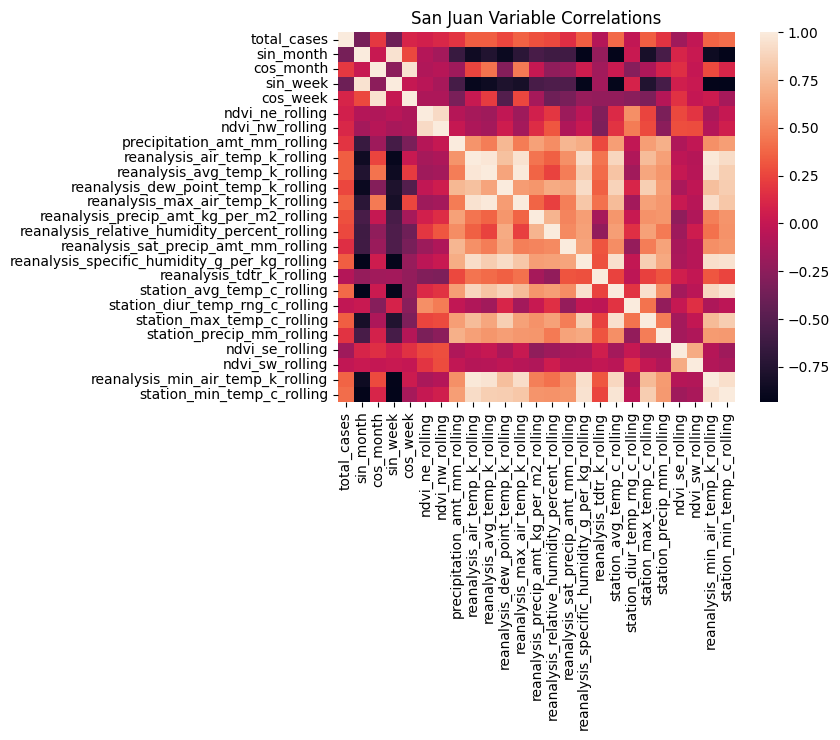

In [6]:
sj_corr_heat = sns.heatmap(Xy_sj.corr())
plt.title('San Juan Variable Correlations')


In [7]:
#(Xy_sj.total_cases
#   .drop('total_cases', axis=1) # don't compare with myself
#   .sort_values(ascending=False)
#   .plot
#   .barh())

In [8]:
# Split data into X and y
X_iq = Xy_iq.drop(labels=['total_cases'], axis=1)
y_iq = Xy_iq['total_cases']
X_sj = Xy_sj.drop(labels=['total_cases'], axis=1)
y_sj = Xy_sj['total_cases']
assert len(X_iq) == len(y_iq)

## 3) Train models

### Baseline model

In [9]:
# Baseline model predictions for Iquitos (Iq)
bl_pred_train = np.tile(np.mean(y_iq), len(y_iq))
bl_pred_test = np.tile(np.mean(y_iq), len(y_iq))
print('For Iquitos: ')
regression_evaluation(y_iq, y_iq, bl_pred_train, bl_pred_test)

# Baseline model predictions for San Jose (sj)
bl_pred_train = np.tile(np.mean(y_sj), len(y_sj))
bl_pred_test = np.tile(np.mean(y_sj), len(y_sj))
print('For San Jose: ')
regression_evaluation(y_sj, y_sj, bl_pred_train, bl_pred_test)

For Iquitos: 

    Evaluation metrics:
        RMSE train: 9.24327523359923
        RMSE test: 9.24327523359923
        MAE train: 6.380110930218457
        MAE test: 6.380110930218457 
    
For San Jose: 

    Evaluation metrics:
        RMSE train: 39.06484683794444
        RMSE test: 39.06484683794444
        MAE train: 24.198600995838284
        MAE test: 24.198600995838284 
    


(39.06484683794444, 39.06484683794444, 24.198600995838284, 24.198600995838284)

### Poisson regression model

In [10]:
# Poisson regression model for iq
X, y = X_iq, y_iq
lm.poisson_reg_model(X, y)

/Users/evgeny/miniconda3/envs/dsr-comp/lib/python3.10/site-packages/sklearn/linear_model/_glm/glm.py:284: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/Users/evgeny/miniconda3/envs/dsr-comp/lib/python3.10/site-packages/sklearn/linear_model/_glm/glm.py:284: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/Users/evgeny/miniconda3/envs/dsr-comp/lib/python3.10/site-packages/sklearn/linear_model/_glm/glm.py:284: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERAT

,TSS iteration,rmse_test,rmse_train,mae_test,mae_train,alpha,mat_iter
0,1,8.756995,5.313325,5.556128,3.807471,0.6,100
1,1,8.135930,4.973292,5.085270,3.636458,0.6,200
2,1,8.305684,5.181783,5.116313,3.767132,1.0,100
3,1,8.239617,5.123079,5.073915,3.723836,1.0,200
4,2,12.547003,6.172710,8.924684,4.336889,0.6,100
5,2,12.606445,6.108365,8.643505,4.282611,0.6,200
6,2,12.682206,6.225341,9.145266,4.368420,1.0,100
7,2,12.475613,6.167392,8.552315,4.339529,1.0,200


In [10]:
# Poisson regression model for sj
X, y = X_sj, y_sj
lm.poisson_reg_model(X, y)

/opt/homebrew/Caskroom/miniforge/base/envs/DSR-comp/lib/python3.10/site-packages/sklearn/linear_model/_glm/glm.py:284: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/homebrew/Caskroom/miniforge/base/envs/DSR-comp/lib/python3.10/site-packages/sklearn/linear_model/_glm/glm.py:284: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/homebrew/Caskroom/miniforge/base/envs/DSR-comp/lib/python3.10/site-packages/sklearn/linear_model/_glm/glm.py:284: ConvergenceWarning: lbfgs failed to converg

,TSS iteration,rmse_test,rmse_train,mae_test,mae_train,alpha,mat_iter
0,1,55.416443,28.205653,33.872039,17.856713,0.6,100
1,1,90.417699,20.372544,60.260186,13.767421,0.6,200
2,1,81.524028,20.953977,55.073860,14.091257,1.0,100
3,1,78.550835,21.438583,52.833337,14.090611,1.0,200
4,2,33.323309,37.338462,25.325313,21.820185,0.6,100
5,2,32.581147,36.344658,24.722197,21.379160,0.6,200
6,2,29.997155,36.755073,23.262889,21.566804,1.0,100
7,2,33.583573,35.542425,25.641750,21.211580,1.0,200


<Axes: >

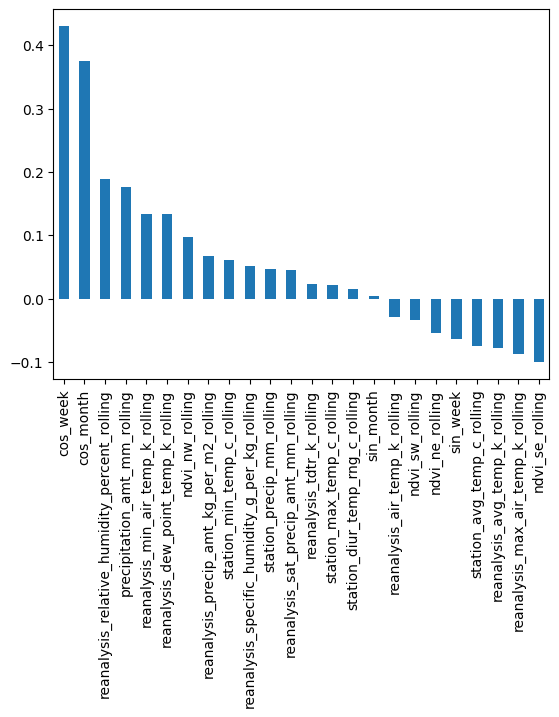

In [11]:
# Poisson get parameters for iq 
X, y = X_iq, y_iq
coefs = lm.poisson_get_coefs(X, y)
coefs.sort_values(ascending=False).plot.bar()

<Axes: >

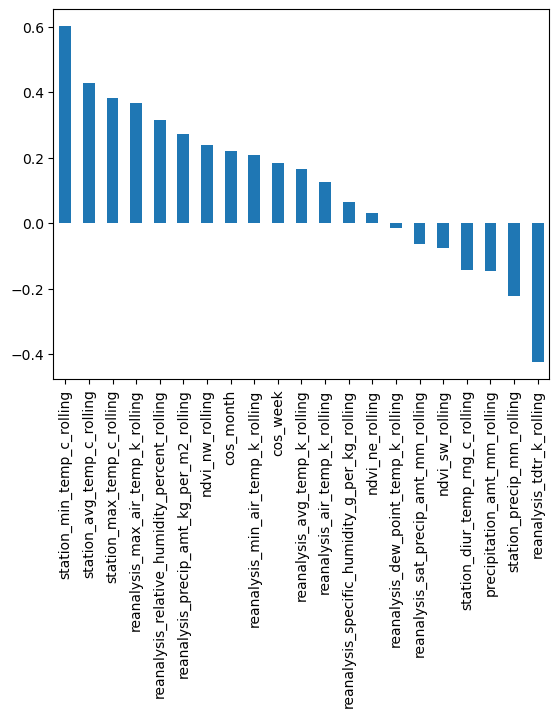

In [12]:
# Poisson get parameters for sj 
X, y = X_sj, y_sj
coefs = lm.poisson_get_coefs(X, y)
coefs.sort_values(ascending=False).plot.bar()

### Random forest model

In [12]:
# Random forest model for iq
X, y = X_iq, y_iq
tm.rforest_model(X, y)

,TSS iteration,rmse_test,rmse_train,mae_test,mae_train,n_estimators,max_depth,min_samples_split,min_samples_leaf
0,1,8.011940,3.494491,5.257857,2.547321,100,4,2,2
1,1,8.113423,3.521841,5.364071,2.549858,100,4,5,2
2,1,8.045475,2.531843,5.248354,1.640509,100,8,2,2
3,1,8.023179,2.661254,5.339801,1.749392,100,8,5,2
4,1,8.140310,3.502946,5.367429,2.515095,200,4,2,2
5,1,8.050544,3.515934,5.300094,2.548895,200,4,5,2
6,1,8.092831,2.513977,5.413561,1.657739,200,8,2,2
7,1,7.991166,2.615660,5.251060,1.739381,200,8,5,2
8,2,11.416466,4.882498,7.003441,3.472641,100,4,2,2
9,2,11.347482,4.887511,7.092995,3.427161,100,4,5,2


In [13]:
# Random forest model for sj
X, y = X_sj, y_sj
tm.rforest_model(X, y)

,TSS iteration,rmse_test,rmse_train,mae_test,mae_train,n_estimators,max_depth,min_samples_split,min_samples_leaf
0,1,39.727897,15.007746,28.274117,9.609039,100,4,2,2
1,1,41.441316,15.281813,29.981396,9.756414,100,4,5,2
2,1,42.609958,8.902851,31.261159,5.200927,100,8,2,2
3,1,42.883099,9.719161,30.883305,5.513028,100,8,5,2
4,1,40.505119,15.038765,29.516473,9.864658,200,4,2,2
5,1,41.246240,15.672847,28.322176,9.890937,200,4,5,2
6,1,42.177623,9.311500,29.178300,5.150490,200,8,2,2
7,1,43.087550,10.209957,31.286662,5.471982,200,8,5,2
8,2,32.687035,22.935909,28.260268,14.846113,100,4,2,2
9,2,31.615378,23.311058,27.015733,14.695235,100,4,5,2


<Axes: >

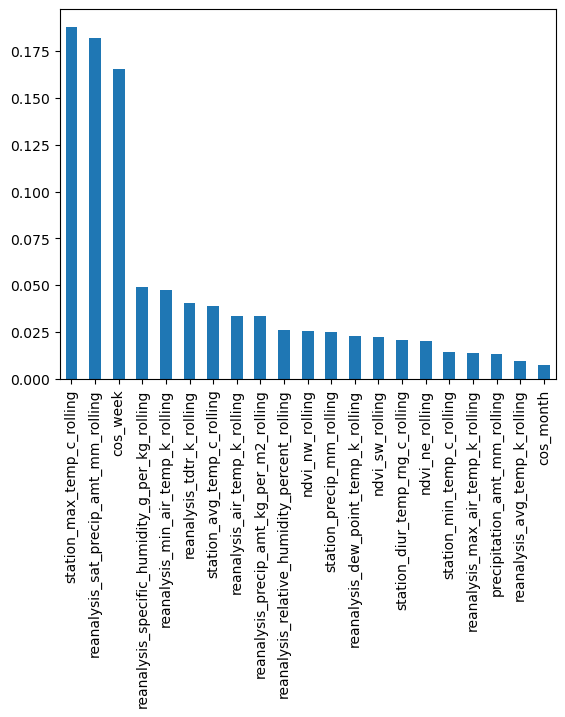

In [17]:
# Random forest feature importance for iq
X, y = X_iq, y_iq
feature_importances = tm.rf_feature_importance(X, y)
feature_importances.sort_values(ascending=False).plot.bar()

<Axes: >

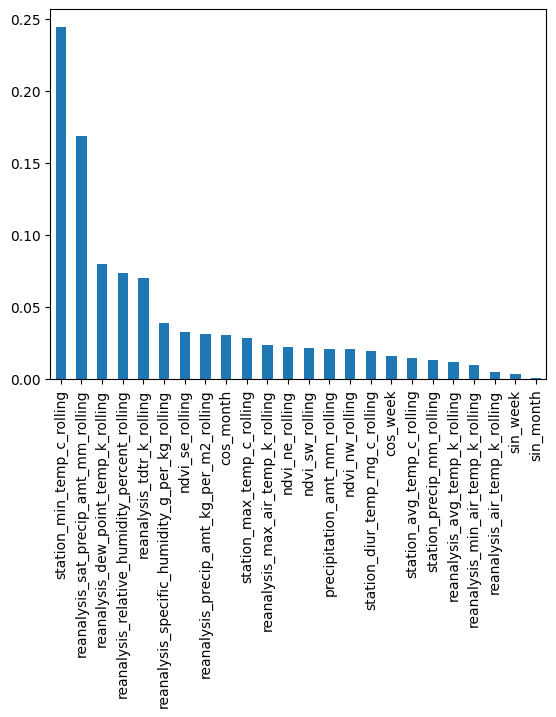

In [14]:
# Random forest feature importance for sj
X, y = X_sj, y_sj
feature_importances = tm.rf_feature_importance(X, y)
feature_importances.sort_values(ascending=False).plot.bar()

### XGBoost model

In [15]:
# XG boost model for iq
X, y = X_iq, y_iq
tm.xg_model(X, y)

,TSS iteration,rmse_test,rmse_train,mae_test,mae_train,learning_rate,n_estimators,max_depth,subsample,colsample_bytree,reg_lambda,gamma
0,1,8.600413,2.219803,5.605889,1.321076,0.05,100,4,0.6,0.8,5,10
1,1,8.541394,2.708503,5.552896,1.612294,0.05,100,4,0.6,0.8,10,10
2,1,8.490269,3.368976,5.613201,1.935281,0.05,100,4,0.6,0.8,20,10
3,1,8.537074,2.120537,5.514380,1.221403,0.05,100,5,0.6,0.8,5,10
4,1,8.524680,2.665326,5.552544,1.530464,0.05,100,5,0.6,0.8,10,10
5,1,8.495934,3.309181,5.602130,1.860147,0.05,100,5,0.6,0.8,20,10
6,1,8.561950,2.111865,5.548569,1.230183,0.05,100,6,0.6,0.8,5,10
7,1,8.586390,2.635225,5.609285,1.512414,0.05,100,6,0.6,0.8,10,10
8,1,8.486415,3.279038,5.638157,1.839867,0.05,100,6,0.6,0.8,20,10
9,2,11.893137,2.645976,7.372844,1.753246,0.05,100,4,0.6,0.8,5,10


In [20]:
# XG boost model for sj
X, y = X_sj, y_sj
tm.xg_model(X, y)

,TSS iteration,rmse_test,rmse_train,mae_test,mae_train,learning_rate,n_estimators,max_depth,subsample,colsample_bytree,reg_lambda,gamma
0,1,46.910965,9.354819,31.827740,4.684922,0.05,100,4,0.6,0.8,5,10
1,1,45.139967,13.379979,29.201191,5.604201,0.05,100,4,0.6,0.8,10,10
2,1,43.058046,18.427317,24.961970,6.771533,0.05,100,4,0.6,0.8,20,10
3,1,45.272638,8.694019,29.646468,3.878841,0.05,100,5,0.6,0.8,5,10
4,1,43.750724,13.108909,26.285055,4.958279,0.05,100,5,0.6,0.8,10,10
5,1,42.729479,18.074365,23.655097,6.318271,0.05,100,5,0.6,0.8,20,10
6,1,44.669047,8.565684,28.938457,3.494187,0.05,100,6,0.6,0.8,5,10
7,1,43.379389,12.925129,25.498828,4.702222,0.05,100,6,0.6,0.8,10,10
8,1,42.521687,17.937667,23.714865,6.106715,0.05,100,6,0.6,0.8,20,10
9,2,28.343101,12.800673,22.833325,7.670477,0.05,100,4,0.6,0.8,5,10


## 4) Predict on test data with chosen model and write file

Repeat the above transforms on the test set

In [16]:
# Code to run pipeline on dataset including test_features, and then take only test_features to run the final model
# Merge features and target data
data = pp.merge_data(train_features, train_target, test_features, inc_test=True)

# Run processing and split by city
Xy_iq_comb = pp.pre_process(data, 'iq', remove_anomalies=True, inc_test=True)
Xy_sj_comb = pp.pre_process(data, 'sj', remove_anomalies=True, inc_test=True)
assert Xy_iq_comb.isnull().any().any() == False
assert Xy_sj_comb.isnull().any().any() == False

# Run feature engineering 
Xy_iq_comb = fe.cyclical_encode_date(Xy_iq_comb)
Xy_sj_comb = fe.cyclical_encode_date(Xy_sj_comb)
#Xy_iq_comb = fe.shift_features(Xy_iq_comb, periods=1)
#Xy_sj_comb = fe.shift_features(Xy_sj_comb, periods=1)
Xy_iq_comb = fe.drop_date(Xy_iq_comb)
Xy_sj_comb = fe.drop_date(Xy_sj_comb)
Xy_iq_comb = fe.add_rolling(Xy_iq_comb, 'iq', fillna=True)
Xy_sj_comb = fe.add_rolling(Xy_sj_comb, 'sj', fillna=True)
Xy_iq_comb = fe.remove_original_cols(Xy_iq_comb)
Xy_sj_comb = fe.remove_original_cols(Xy_sj_comb)
print(f'Xy_iq_comb shape: {Xy_iq_comb.shape}') 
print(f'Xy_sj_comb shape: {Xy_sj_comb.shape}') 

# Split data into X and y
X_iq_comb = Xy_iq_comb.drop(labels=['total_cases'], axis=1)
y_train_iq = Xy_iq_comb.loc[Xy_iq_comb['total_cases'] >= 0, Xy_iq_comb.columns == 'total_cases']
y_test_iq = Xy_iq_comb.loc[Xy_iq_comb['total_cases'] < 0, Xy_iq_comb.columns == 'total_cases']
X_sj_comb = Xy_sj_comb.drop(labels=['total_cases'], axis=1)
y_train_sj = Xy_sj_comb.loc[Xy_sj_comb['total_cases'] >= 0, Xy_sj_comb.columns == 'total_cases']
y_test_sj = Xy_sj_comb.loc[Xy_sj_comb['total_cases'] < 0, Xy_sj_comb.columns == 'total_cases']

# Take now only the test features 
X_train_iq = X_iq_comb.iloc[:(X_iq_comb.shape[0] - y_test_iq.shape[0]) , :]
X_train_sj = X_sj_comb.iloc[:(X_sj_comb.shape[0] - y_test_sj.shape[0]) , :]
X_test_iq = X_iq_comb.iloc[(X_iq_comb.shape[0] - y_test_iq.shape[0]): , :]
X_test_sj = X_sj_comb.iloc[(X_sj_comb.shape[0] - y_test_sj.shape[0]): , :]

print(X_train_iq.shape, y_train_iq.shape)
print(X_train_sj.shape, y_train_sj.shape)
assert (X_train_iq.shape[0] == y_train_iq.shape[0])
assert (X_train_sj.shape[0] == y_train_sj.shape[0])


Xy_iq_comb shape: (619, 25)
Xy_sj_comb shape: (1188, 25)
(463, 24) (463, 1)
(928, 24) (928, 1)


In [17]:
# Select data and chosen model and hyperparameters for final prediction

params = dict(learning_rate=0.05,
        n_estimators=120,
        max_depth=6,
        subsample=0.6,
        colsample_bytree=0.8,
        reg_lambda=8,
        gamma=8)
 
# Iquitos, iq
X_test_iq = X_test_iq
X_train_iq = X_train_iq
y_train_iq = y_train_iq
model_iq = 'XGBRegressor'
params_iq = params

# San Jose, sj
X_test_sj = X_test_sj
X_train_sj = X_train_sj
y_train_sj = y_train_sj
model_sj = 'XGBRegressor'
params_sj = params


In [18]:
# Do final prediction and create final DataFrame for submission 
iq_preds = fp.final_predict(X_test_iq, X_train_iq, y_train_iq, city='iq', model=model_iq, params=params_iq)
sj_preds = fp.final_predict(X_test_sj, X_train_sj, y_train_sj, city='sj', model=model_sj, params=params_sj)
final_iq = test_features.loc[test_features.city == 'iq', ['city','year','weekofyear']]
final_sj = test_features.loc[test_features.city == 'sj', ['city','year','weekofyear']]

assert len(iq_preds) == final_iq.shape[0]
assert len(sj_preds) == final_sj.shape[0]

final_iq['total_cases'] = iq_preds.tolist()
final_sj['total_cases'] = sj_preds.tolist()
final = pd.concat([final_sj, final_iq], axis=0)
final['total_cases'] = final['total_cases'].astype(int)

assert final.isnull().any().any() == False
assert final.shape[0] == 416


In [19]:
preds_train_iq, y_train_iq = fp.preds_for_plot(X_test_iq, X_train_iq, y_train_iq, model=model_iq, params=params_iq)
preds_train_sj, y_train_sj = fp.preds_for_plot(X_test_sj, X_train_sj, y_train_sj, model=model_sj, params=params_sj)

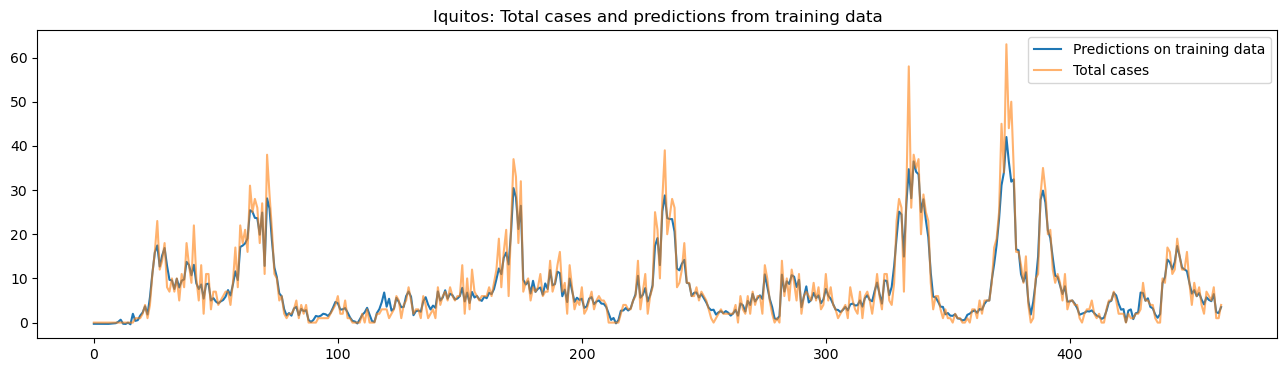

In [43]:
plt.figure(figsize=(16,4))
x = np.arange(preds_train_iq.shape[0])
plt.plot(x, preds_train_iq, label='Predictions on training data')
plt.plot(x, y_train_iq, label='Total cases', alpha=0.6)
plt.title('Iquitos: Total cases and predictions from training data')
plt.legend();

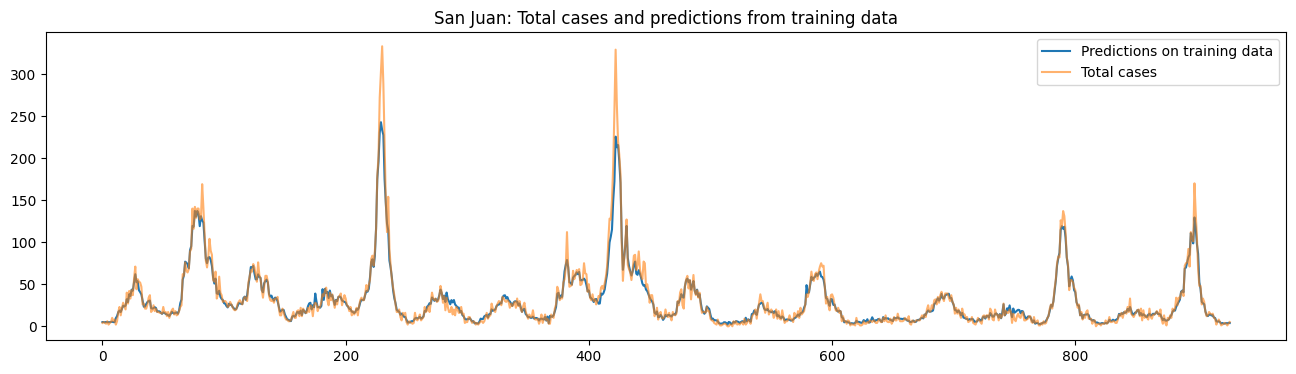

In [20]:
plt.figure(figsize=(16,4))
x = np.arange(preds_train_sj.shape[0])
plt.plot(x, preds_train_sj, label='Predictions on training data')
plt.plot(x, y_train_sj, label='Total cases', alpha=0.6)
plt.title('San Juan: Total cases and predictions from training data')
plt.legend();

In [21]:
# Write to file for submission 
print('Writing submission file to folder: ')
final.to_csv('submission_XGB_less_features.csv', index=False)

Writing submission file to folder: 


SCORE: 26

In [22]:
import plotly.io as pio
pio.renderers.default = "browser"
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import MinMaxScaler
import plotly.express as px

scaler = MinMaxScaler()
sj_scaled = scaler.fit_transform(Xy_sj)
sj_scaled = pd.DataFrame(columns=Xy_sj.columns, data= sj_scaled, index=Xy_sj.index)
iq_scaled = scaler.fit_transform(Xy_iq)
iq_scaled = pd.DataFrame(columns=Xy_iq.columns, data= iq_scaled, index=Xy_iq.index)

fig = make_subplots(rows=2, cols=1, shared_xaxes=True, subplot_titles = ["San Juan", "Iquitos"], 
                    vertical_spacing=0.02)
n_colors = iq_scaled.shape[1]
colors = px.colors.sample_colorscale("turbo", [n/(n_colors -1) for n in range(n_colors)])


for i, c in enumerate(sj_scaled.columns):
    fig.add_trace(go.Scatter(x=sj_scaled.index, 
                             y=sj_scaled.loc[:,c],
                             mode='lines', # 'lines' or 'markers'
                             name=c,
                             line_color=colors[i],
                             legendgroup=f'group{i}',
                             showlegend=False,),
                  
                  row=1, col=1)

for i, c in enumerate(iq_scaled.columns):
    fig.add_trace(go.Scatter(x=iq_scaled.index, 
                             y=iq_scaled.loc[:,c],
                             mode='lines', # 'lines' or 'markers'
                             line_color=colors[i],
                             legendgroup=f'group{i}',
                             name=c),
                 row=2, col=1)
fig.show()